# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                   
Sample_062  Q07954                                              15.948
Sample_016  B1AN99;P35030;P35030-2;P35030-3;P35030-4;P35030-5   19.276
Sample_142  A0A087X1V2                                          16.885
Sample_209  B1AJR6;B1AJR9;B1AJS0;O14522                         14.373
Sample_037  Q96MK3                                              16.016
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                 
Sample_124  P06732                            14.139
Sample_087  E7EWD3;O75077;O75077-2;O75077-3   16.048
Sample_034  P00533;P00533-3;P00533-4          14.037
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.703
            A0A075B6Q5                 13.907
            A0A075B6R2                 12.956
            A0A075B6S5                 13.251
            A0A087WSY4                 15.436
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.250
            Q9UI40;Q9UI40-2            13.809
            Q9UIW2                     11.209
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.609
            Q9UP79                     12.220
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.500,15.050,16.842,19.863,16.050,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.808,19.067,...,15.528,15.576,14.337,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.910,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.272,17.705,17.039,15.992,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.312,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.330,15.345,17.084,18.708,14.249,19.433,10.690,11.137
Sample_207,15.739,16.877,15.469,16.898,14.757,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.595,14.370,13.516,12.147,14.240,11.901,12.640,12.421,13.382,12.752
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.640,19.067,16.127,...,12.799,11.259,10.798,13.379,12.366,12.532,12.356,12.547,12.090,13.443
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.413,13.371,13.850,12.985,12.464,13.706,12.288,12.982,12.872,12.409
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.879,11.857,12.025,14.050,12.201,13.708,13.767,13.463,13.171,13.356
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.871,14.050,13.440,12.625,13.693,12.882,12.938,13.251,12.564,13.632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.609,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 327.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.32it/s]

100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.47it/s]

100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.35it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.25it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.57it/s]

100%|██████████| 5/5 [00:00<00:00,  5.10it/s]

100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.65it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.48it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.28it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.73it/s]

100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

100%|██████████| 6/6 [00:01<00:00,  5.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.00it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.11it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.78it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.73it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.62it/s]

100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.20it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.36it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.95it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.86it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.75it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.88it/s]

100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

100%|██████████| 8/8 [00:01<00:00,  5.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.33it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.59it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.25it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.88it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.80it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.99it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.89it/s]

100%|██████████| 9/9 [00:01<00:00,  4.90it/s]

100%|██████████| 9/9 [00:01<00:00,  5.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.05it/s]

 30%|███       | 3/10 [00:00<00:01,  5.76it/s]

 40%|████      | 4/10 [00:00<00:01,  5.21it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.05it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.83it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.73it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.72it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.81it/s]

100%|██████████| 10/10 [00:01<00:00,  4.84it/s]

100%|██████████| 10/10 [00:01<00:00,  5.04it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.24it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.14it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.35it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.47it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.45it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.68it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.01it/s]

 91%|█████████ | 10/11 [00:02<00:00,  5.20it/s]

100%|██████████| 11/11 [00:02<00:00,  5.29it/s]

100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.71it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.77it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.20it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.93it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.78it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.66it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.91it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.02it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.19it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.94it/s]

100%|██████████| 12/12 [00:02<00:00,  3.82it/s]

100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.42it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.87it/s]

 31%|███       | 4/13 [00:00<00:02,  4.00it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.89it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.79it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.88it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.95it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.20it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.05it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.94it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.81it/s]

100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

100%|██████████| 13/13 [00:03<00:00,  3.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.49it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.26it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.65it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.99it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.13it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.98it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.08it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.97it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.21it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.12it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.03it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.90it/s]

100%|██████████| 14/14 [00:03<00:00,  3.88it/s]

100%|██████████| 14/14 [00:03<00:00,  4.05it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.23it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.61it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.44it/s]

 40%|████      | 6/15 [00:01<00:02,  4.02it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.70it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.85it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.17it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.53it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.56it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.73it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.98it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.14it/s]

100%|██████████| 15/15 [00:03<00:00,  5.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.043 0.014          0.751 0.365       0.121   
2             0.004 0.004      0.043 0.018          0.701 0.126       0.631   
3             0.005 0.004      0.045 0.017          0.691 0.111       0.617   
4             0.004 0.002      0.046 0.017          0.707 0.109       0.625   
5             0.005 0.004      0.049 0.018          0.693 0.095       0.669   
6             0.005 0.006      0.043 0.014          0.815 0.083       0.822   
7             0.005 0.004      0.046 0.017          0.809 0.085       0.824   
8             0.004 0.003      0.045 0.016          0.814 0.087       0.824   
9             0.004 0.003      0.042 0.014          0.823 0.083       0.827   
10            0.004 0.002      0.042 0.014          0.822 0.086       0.822   
11            0.002 0.000      0.020 0.000          0.807 0.081       0.821   
12            0.003 0.000      0.034 0.004          0.811 0.091       0.822   
13            0.004 0.002      0.038 0.006          0.834 0.085       0.819   
14            0.003 0.002      0.028 0.010          0.822 0.088       0.814   
15            0.003 0.001      0.027 0.007          0.818 0.086       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.089   0.201 0.135                  0.553 0.043        0.850   
2          0.127   0.654 0.093                  0.710 0.075        0.787   
3          0.131   0.641 0.092                  0.702 0.071        0.785   
4          0.116   0.656 0.087                  0.714 0.067        0.807   
5          0.118   0.674 0.081                  0.723 0.066        0.811   
6          0.099   0.814 0.066                  0.841 0.056        0.903   
7          0.103   0.812 0.072                  0.840 0.061        0.901   
8          0.102   0.815 0.072                  0.842 0.060        0.901   
9          0.111   0.820 0.074                  0.847 0.062        0.909   
10         0.112   0.817 0.076                  0.845 0.064        0.908   
11         0.107   0.809 0.070                  0.837 0.059        0.905   
12         0.101   0.812 0.072                  0.839 0.062        0.906   
13         0.104   0.822 0.074                  0.848 0.063        0.913   
14         0.103   0.814 0.075                  0.841 0.064        0.912   
15         0.098   0.811 0.074                  0.839 0.062        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.074                  0.729 0.093        210.000 0.000  
3          0.075                  0.716 0.095        210.000 0.000  
4          0.071                  0.756 0.099        210.000 0.000  
5          0.066                  0.762 0.094        210.000 0.000  
6          0.049                  0.878 0.063        210.000 0.000  
7          0.050                  0.875 0.064        210.000 0.000  
8          0.050                  0.879 0.062        210.000 0.000  
9          0.050                  0.897 0.053        210.000 0.000  
10         0.051                  0.895 0.054        210.000 0.000  
11         0.051                  0.892 0.054        210.000 0.000  
12         0.052                  0.896 0.052        210.000 0.000  
13         0.051                  0.904 0.049        210.000 0.000  
14         0.050                  0.903 0.049        210.000 0.000  
15         0.051                  0.901 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 564.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.79it/s]

100%|██████████| 3/3 [00:00<00:00,  6.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.94it/s]

100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

100%|██████████| 4/4 [00:00<00:00,  8.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 12.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.78it/s]

100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

100%|██████████| 5/5 [00:00<00:00,  7.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.05it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.55it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.94it/s]

100%|██████████| 6/6 [00:00<00:00,  5.63it/s]

100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.54it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.56it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  7.07it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.81it/s]

100%|██████████| 7/7 [00:00<00:00,  6.57it/s]

100%|██████████| 7/7 [00:00<00:00,  7.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.18it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.03it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.11it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.06it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.01it/s]

100%|██████████| 8/8 [00:01<00:00,  5.98it/s]

100%|██████████| 8/8 [00:01<00:00,  6.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.64it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.47it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.81it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.80it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.73it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.70it/s]

100%|██████████| 9/9 [00:01<00:00,  5.74it/s]

100%|██████████| 9/9 [00:01<00:00,  6.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.31it/s]

 40%|████      | 4/10 [00:00<00:00,  7.61it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.09it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.71it/s]

 70%|███████   | 7/10 [00:00<00:00,  6.59it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.49it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.50it/s]

100%|██████████| 10/10 [00:01<00:00,  5.45it/s]

100%|██████████| 10/10 [00:01<00:00,  6.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.52it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.81it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.18it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.76it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.50it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.32it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.25it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.25it/s]

100%|██████████| 11/11 [00:01<00:00,  6.26it/s]

100%|██████████| 11/11 [00:01<00:00,  6.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.34it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.74it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.47it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.70it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.92it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.56it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.58it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.90it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.08it/s]

100%|██████████| 12/12 [00:02<00:00,  4.14it/s]

100%|██████████| 12/12 [00:02<00:00,  4.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.45it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.93it/s]

 31%|███       | 4/13 [00:01<00:02,  3.63it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.56it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.92it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.11it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.19it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.46it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.54it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.42it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.56it/s]

100%|██████████| 13/13 [00:03<00:00,  4.70it/s]

100%|██████████| 13/13 [00:03<00:00,  4.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.33it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.52it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.84it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.46it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.13it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.29it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.29it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.14it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.32it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.28it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.47it/s]

100%|██████████| 14/14 [00:02<00:00,  6.45it/s]

100%|██████████| 14/14 [00:02<00:00,  6.57it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.83it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.27it/s]

 40%|████      | 6/15 [00:00<00:01,  8.99it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.48it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  7.95it/s]

 60%|██████    | 9/15 [00:01<00:00,  7.31it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.04it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.93it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.73it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.12it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  6.15it/s]

100%|██████████| 15/15 [00:02<00:00,  6.18it/s]

100%|██████████| 15/15 [00:02<00:00,  7.27it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.036 0.016          0.053 0.192       0.006   
2             0.002 0.001      0.025 0.007          0.699 0.096       0.506   
3             0.002 0.000      0.020 0.002          0.692 0.097       0.513   
4             0.002 0.000      0.021 0.004          0.688 0.098       0.517   
5             0.002 0.000      0.021 0.004          0.757 0.092       0.615   
6             0.002 0.000      0.020 0.001          0.745 0.093       0.612   
7             0.002 0.001      0.022 0.005          0.785 0.105       0.740   
8             0.002 0.001      0.023 0.006          0.783 0.107       0.739   
9             0.002 0.000      0.021 0.005          0.817 0.100       0.775   
10            0.002 0.000      0.021 0.003          0.812 0.099       0.757   
11            0.002 0.001      0.024 0.006          0.812 0.103       0.783   
12            0.003 0.001      0.032 0.008          0.809 0.100       0.781   
13            0.002 0.001      0.023 0.005          0.838 0.091       0.794   
14            0.002 0.001      0.020 0.003          0.839 0.098       0.804   
15            0.002 0.000      0.020 0.000          0.838 0.094       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.021   0.010 0.038                  0.499 0.011        0.860   
2          0.113   0.579 0.091                  0.672 0.054        0.716   
3          0.117   0.581 0.092                  0.672 0.055        0.707   
4          0.115   0.582 0.090                  0.671 0.056        0.700   
5          0.116   0.673 0.087                  0.735 0.060        0.800   
6          0.111   0.666 0.086                  0.729 0.061        0.797   
7          0.120   0.755 0.085                  0.793 0.068        0.891   
8          0.122   0.753 0.088                  0.792 0.071        0.889   
9          0.106   0.788 0.071                  0.820 0.057        0.909   
10         0.113   0.777 0.081                  0.812 0.065        0.907   
11         0.108   0.790 0.075                  0.821 0.061        0.912   
12         0.109   0.787 0.073                  0.819 0.061        0.912   
13         0.108   0.809 0.075                  0.839 0.061        0.921   
14         0.113   0.815 0.080                  0.843 0.065        0.920   
15         0.107   0.814 0.075                  0.842 0.061        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.828 0.088        210.000 0.000  
2          0.072                  0.706 0.074        210.000 0.000  
3          0.071                  0.692 0.073        210.000 0.000  
4          0.073                  0.681 0.075        210.000 0.000  
5          0.069                  0.766 0.092        210.000 0.000  
6          0.069                  0.762 0.091        210.000 0.000  
7          0.054                  0.865 0.069        210.000 0.000  
8          0.054                  0.861 0.070        210.000 0.000  
9          0.046                  0.881 0.064        210.000 0.000  
10         0.049                  0.879 0.066        210.000 0.000  
11         0.047                  0.882 0.066        210.000 0.000  
12         0.048                  0.882 0.069        210.000 0.000  
13         0.045                  0.895 0.062        210.000 0.000  
14         0.045                  0.898 0.060        210.000 0.000  
15         0.045                  0.896 0.059 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1118.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 65.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.84it/s]

100%|██████████| 5/5 [00:00<00:00, 43.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.65it/s]

100%|██████████| 6/6 [00:00<00:00, 41.69it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.24it/s]

100%|██████████| 7/7 [00:00<00:00, 39.65it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.89it/s]

100%|██████████| 8/8 [00:00<00:00, 40.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.87it/s]

100%|██████████| 9/9 [00:00<00:00, 39.37it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.77it/s]

100%|██████████| 10/10 [00:00<00:00, 38.25it/s]

100%|██████████| 10/10 [00:00<00:00, 38.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.01it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.37it/s]

100%|██████████| 11/11 [00:00<00:00, 38.59it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.84it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.28it/s]

100%|██████████| 12/12 [00:00<00:00, 38.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.56it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.23it/s]

100%|██████████| 13/13 [00:00<00:00, 37.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.97it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.34it/s]

100%|██████████| 14/14 [00:00<00:00, 37.05it/s]

100%|██████████| 14/14 [00:00<00:00, 37.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.59it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.21it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.06it/s]

100%|██████████| 15/15 [00:00<00:00, 37.61it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.001          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.479 0.311       0.097   
3             0.002 0.000      0.020 0.000          0.539 0.251       0.147   
4             0.002 0.000      0.020 0.000          0.516 0.226       0.157   
5             0.002 0.000      0.020 0.000          0.482 0.234       0.150   
6             0.002 0.000      0.019 0.000          0.637 0.112       0.536   
7             0.002 0.000      0.020 0.001          0.662 0.085       0.597   
8             0.002 0.000      0.020 0.000          0.652 0.086       0.583   
9             0.002 0.000      0.020 0.000          0.650 0.096       0.588   
10            0.002 0.000      0.020 0.000          0.639 0.088       0.581   
11            0.002 0.000      0.020 0.000          0.639 0.095       0.575   
12            0.002 0.000      0.020 0.000          0.635 0.091       0.568   
13            0.002 0.000      0.020 0.000          0.645 0.090       0.568   
14            0.002 0.000      0.020 0.000          0.642 0.093       0.559   
15            0.002 0.000      0.020 0.000          0.673 0.091       0.606   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.744   
2          0.070   0.154 0.104                  0.513 0.040        0.593   
3          0.076   0.223 0.106                  0.525 0.045        0.560   
4          0.073   0.234 0.097                  0.521 0.047        0.537   
5          0.079   0.223 0.104                  0.517 0.048        0.519   
6          0.115   0.577 0.103                  0.655 0.080        0.754   
7          0.103   0.621 0.077                  0.685 0.057        0.786   
8          0.107   0.610 0.083                  0.676 0.060        0.780   
9          0.111   0.611 0.086                  0.675 0.064        0.778   
10         0.117   0.602 0.088                  0.669 0.065        0.774   
11         0.123   0.597 0.091                  0.666 0.067        0.770   
12         0.116   0.592 0.085                  0.662 0.063        0.767   
13         0.114   0.596 0.082                  0.667 0.059        0.765   
14         0.110   0.590 0.080                  0.662 0.059        0.761   
15         0.113   0.632 0.089                  0.694 0.068        0.780   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.695 0.084        210.000 0.000  
2          0.065                  0.534 0.057        210.000 0.000  
3          0.061                  0.522 0.063        210.000 0.000  
4          0.064                  0.507 0.062        210.000 0.000  
5          0.064                  0.491 0.068        210.000 0.000  
6          0.073                  0.695 0.081        210.000 0.000  
7          0.066                  0.734 0.078        210.000 0.000  
8          0.067                  0.729 0.080        210.000 0.000  
9          0.069                  0.727 0.082        210.000 0.000  
10         0.068                  0.720 0.084        210.000 0.000  
11         0.069                  0.717 0.084        210.000 0.000  
12         0.069                  0.713 0.084        210.000 0.000  
13         0.069                  0.708 0.083        210.000 0.000  
14         0.069                  0.701 0.086        210.000 0.000  
15         0.069                  0.719 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,1,15
score_time,5,1,15
test_precision,13,14,15
test_recall,9,14,15
test_f1,13,14,15
test_balanced_accuracy,13,14,15
test_roc_auc,13,13,7
test_average_precision,13,14,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.80it/s]

 31%|███       | 4/13 [00:00<00:00, 10.17it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.03it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  8.72it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.51it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  8.35it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.30it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.20it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.26it/s]

100%|██████████| 13/13 [00:01<00:00,  8.26it/s]

100%|██████████| 13/13 [00:01<00:00,  8.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.88it/s]

100%|██████████| 7/7 [00:00<00:00, 40.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.87it/s]

 31%|███       | 4/13 [00:00<00:00, 11.99it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.68it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 10.14it/s]

 77%|███████▋  | 10/13 [00:00<00:00,  9.94it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.83it/s]

100%|██████████| 13/13 [00:01<00:00, 10.31it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


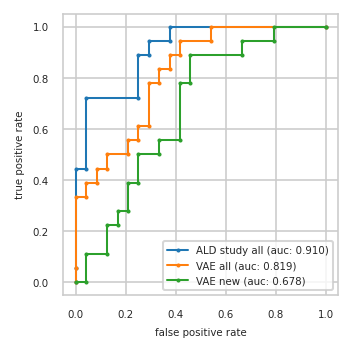

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.444   0.000 0.333   0.042 0.111
3          0.042 0.444   0.042 0.333   0.125 0.111
4          0.042 0.722   0.042 0.389   0.125 0.222
5          0.250 0.722   0.083 0.389   0.167 0.222
6          0.250 0.889   0.083 0.444   0.167 0.278
7          0.292 0.889   0.125 0.444   0.208 0.278
8          0.292 0.944   0.125 0.500   0.208 0.389
9          0.375 0.944   0.208 0.500   0.250 0.389
10         0.375 1.000   0.208 0.556   0.250 0.500
11         1.000 1.000   0.250 0.556   0.333 0.500
12           NaN   NaN   0.250 0.611   0.333 0.556
13           NaN   NaN   0.292 0.611   0.417 0.556
14           NaN   NaN   0.292 0.778   0.417 0.778
15           NaN   NaN   0.333 0.778   0.458 0.778
16           NaN   NaN   0.333 0.833   0.458 0.889
17           NaN   NaN   0.375 0.833   0.667 0.889
18           NaN   NaN   0.375 0.889   0.667 0.944
19           NaN   NaN   0.417 0.889   0.792 0.944
20           NaN   NaN   0.417 0.944   0.792 1.000
21           NaN   NaN   0.542 0.944   1.000 1.000
22           NaN   NaN   0.542 1.000     NaN   NaN
23           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YX35,B8ZZ19;H0Y3U0;P20472,P08582
2,B8ZZ19;H0Y3U0;P20472,F5GWQ8;J3QKW8;Q15846,P51688
3,P61981,P61981,P31321
4,A0A0A0MRJ7;P12259,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P04075,P04075,Q9NUQ9
6,P14174,P14174,Q96GD0
7,P00338;P00338-3,Q14894,None
8,Q9Y2T3;Q9Y2T3-3,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


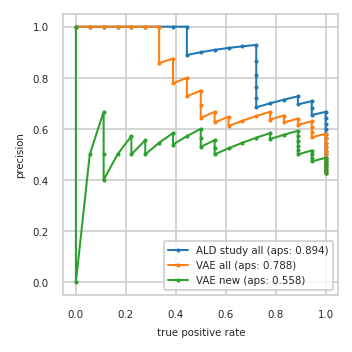

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.630 0.944     0.593 0.889
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.708 0.944     0.625 0.833     0.583 0.778
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.700 0.778     0.650 0.722     0.500 0.556
23         0.684 0.722     0.632 0.667     0.526 0.556
24         0.722 0.722     0.611 0.611     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.812 0.722     0.625 0.556     0.562 0.500
27         0.867 0.722     0.667 0.556     0.600 0.500
28         0.929 0.722     0.643 0.500     0.571 0.444
29         0.923 0.667     0.692 0.500     0.538 0.389
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


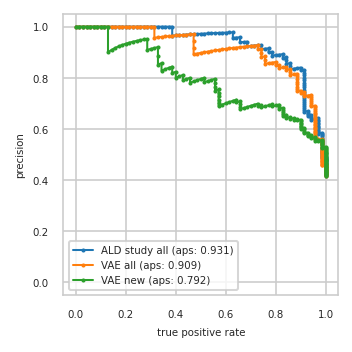

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


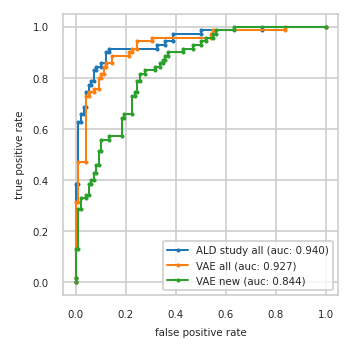

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}